# Comparing weakly constraint network with and without adiabatic terms

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from cbrain.imports import *
limit_mem()
from cbrain.utils import *
from cbrain.normalization import conversion_dict
from cbrain.data_generator import DataGenerator
from cbrain.model_diagnostics.model_diagnostics import ModelDiagnostics
from tensorflow.python.ops.parallel_for.gradients import jacobian

In [3]:
md3 = ModelDiagnostics('../../nn_config/003_8col_weak.yml', '/local/S.Rasp/preprocessed_data/001_valid.nc')

In [5]:
md3.compute_stats(250)

/home/s/S.Rasp/repositories/CBRAIN-CAM/notebooks/stephans-devlog/cbrain/model_diagnostics/model_diagnostics.py:130: RuntimeWarning: divide by zero encountered in true_divide
  self.stats['r2'] = 1. - (self.stats['mse'] / self.stats['true_var'])
/home/s/S.Rasp/repositories/CBRAIN-CAM/notebooks/stephans-devlog/cbrain/model_diagnostics/model_diagnostics.py:136: RuntimeWarning: divide by zero encountered in true_divide
  self.stats['hor_r2'] = 1 - (self.stats['hor_mse'] / self.stats['hor_tvar'])


In [113]:
md4 = ModelDiagnostics('../../nn_config/004_8col_weak_noadiab.yml', '/local/S.Rasp/preprocessed_data/001_valid.nc')

In [7]:
md4.compute_stats(250)

/home/s/S.Rasp/repositories/CBRAIN-CAM/notebooks/stephans-devlog/cbrain/model_diagnostics/model_diagnostics.py:130: RuntimeWarning: divide by zero encountered in true_divide
  self.stats['r2'] = 1. - (self.stats['mse'] / self.stats['true_var'])
/home/s/S.Rasp/repositories/CBRAIN-CAM/notebooks/stephans-devlog/cbrain/model_diagnostics/model_diagnostics.py:136: RuntimeWarning: divide by zero encountered in true_divide
  self.stats['hor_r2'] = 1 - (self.stats['hor_mse'] / self.stats['hor_tvar'])


In [110]:
md2 = ModelDiagnostics('../../nn_config/002_8col_strong.yml', '/local/S.Rasp/preprocessed_data/001_valid.nc')

In [15]:
# Get the vertical coordinate in pressure levels
PS = 1e5; P0 = 1e5;
P = P0*hyai+PS*hybi; # Total pressure [Pa]
P = (P[1:] + P[:-1]) / 2 / 100

## R2 by height

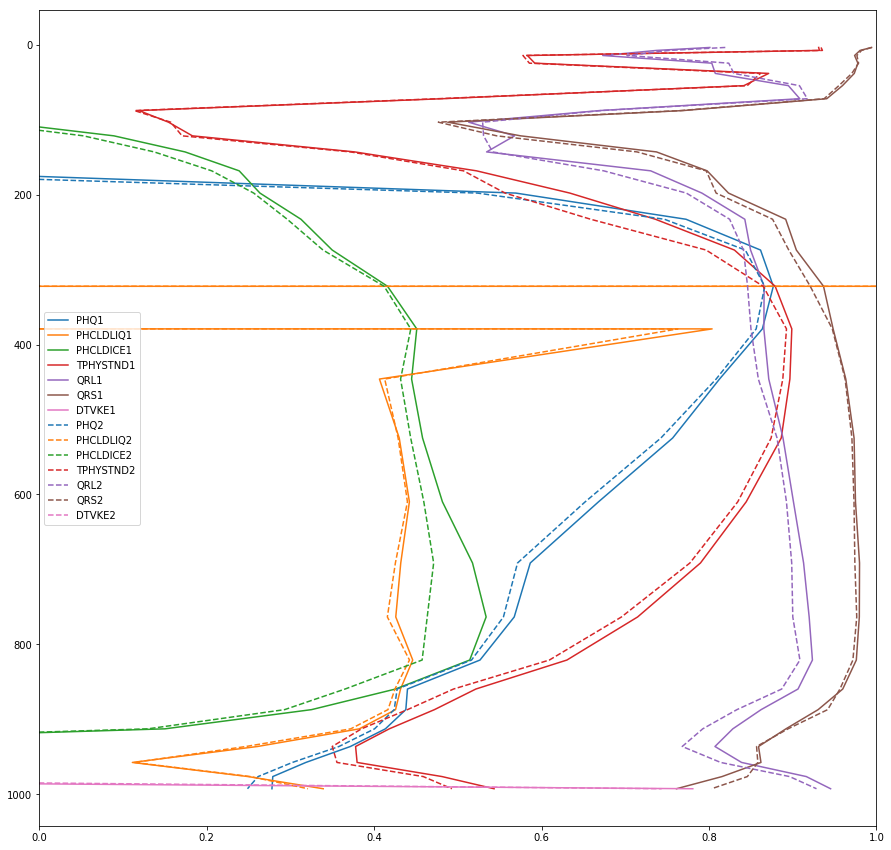

In [10]:
cols = sns.color_palette(n_colors=7)
fig, ax = plt.subplots(figsize=(15, 15))
for i, (md, sty) in enumerate(zip([md3, md4], ['-','--'])):
    for v, c in zip(md3.valid_gen.output_vars[:7], cols):
        if v in md.valid_gen.output_vars:
            ax.plot(md.stats['hor_r2'][md.get_output_var_idx(v)], P, label=v+str(i+1), ls=sty, c=c)
ax.set_xlim(0, 1)
ax.invert_yaxis()
plt.legend()

## Computing the Jacobian
https://medium.com/unit8-machine-learning-publication/computing-the-jacobian-matrix-of-a-neural-network-in-python-4f162e5db180

In [7]:
md3.model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 304)               0         
_________________________________________________________________
dense (Dense)                (None, 256)               78080     
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               65792     
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 256)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 256)               65792     
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 256)               0         
__________

### Get mean sounding

In [4]:
X, Y = md3.valid_gen[0]; X.shape

(8192, 304)

In [5]:
X = md3.reshape_ngeo(np.array(X)); X.shape

(64, 128, 304)

In [6]:
Y.shape

(8192, 218)

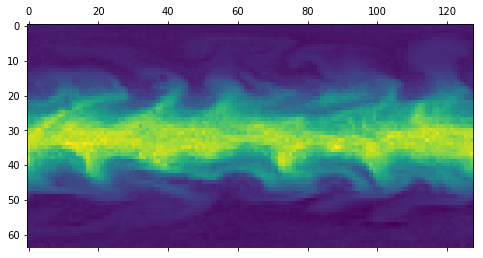

In [7]:
plt.matshow(X[:, :, 29])

In [86]:
X_mean = X[30:32].mean((0,1)); X_mean.shape

(304,)

In [115]:
X_mean_noadiab = md4.reshape_ngeo(np.array(md4.valid_gen[0][0], dtype=np.float32))[30:32].mean((0,1)); X_mean_noadiab.shape

(154,)

### Compute 

In [87]:
def get_jacobian(x, model):
    sess = tf.keras.backend.get_session()
    jac = jacobian(model.output, model.input)
    J = sess.run(jac, feed_dict={model.input: x.astype(np.float32)[None]})
    return J.squeeze()

In [111]:
J2 = get_jacobian(X_mean, md2.model)

/home/s/S.Rasp/miniconda3/envs/tf/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:112: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


In [107]:
J3 = get_jacobian(X_mean, md3.model)

/home/s/S.Rasp/miniconda3/envs/tf/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:112: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


In [116]:
J4 = get_jacobian(X_mean_noadiab, md4.model)

/home/s/S.Rasp/miniconda3/envs/tf/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:112: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


In [103]:
def plot_jacobian(J, gen, inp_var=None, out_var=None, figsize=(15, 15), ax = None, **kwargs):
    inp_vars = gen.norm_ds.var_names[gen.input_idxs].values
    out_vars = gen.norm_ds.var_names[gen.output_idxs].values
    inp_idxs = np.where(inp_vars == inp_var)[0]
    out_idxs = np.where(out_vars == out_var)[0]
    j = J[out_idxs][:, inp_idxs]
    PP = np.meshgrid(P, P)
    if ax is None: 
        fig, ax = plt.subplots(figsize=figsize)
    else:
        fig = plt.gcf()
    pc = ax.pcolormesh(PP[0], PP[1], j, **kwargs)
    ax.invert_xaxis(); ax.invert_yaxis()
    fig.colorbar(pc, shrink=0.7, ax=ax)
    ax.set_aspect('equal')
    ax.set_xlabel(inp_var)
    ax.set_ylabel(out_var)

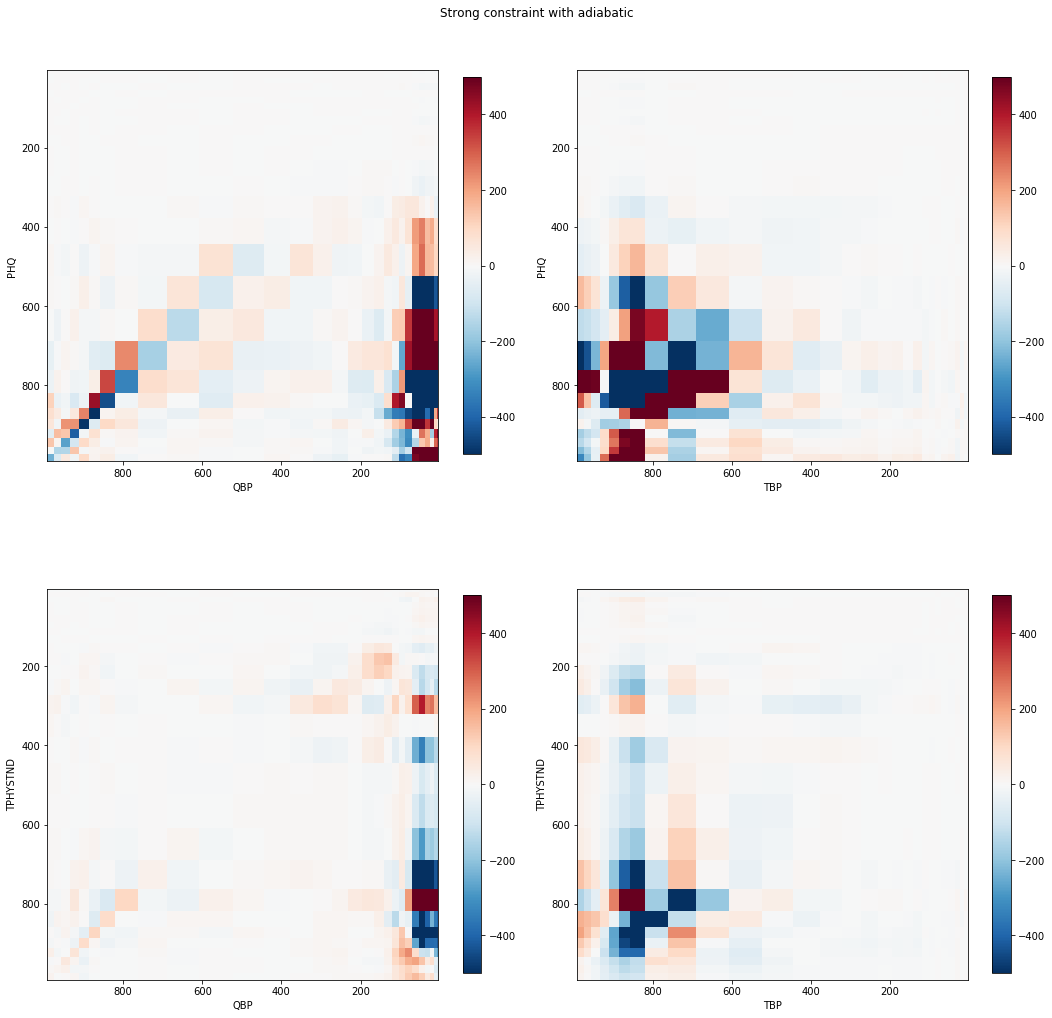

In [119]:
fig, axs = plt.subplots(2, 2, figsize=(15,15))
plot_jacobian(J2, md2.valid_gen, inp_var='QBP', out_var='PHQ', cmap='RdBu_r', vmin=-500, vmax=500, ax=axs[0,0])
plot_jacobian(J2, md2.valid_gen, inp_var='TBP', out_var='PHQ', cmap='RdBu_r', vmin=-500, vmax=500, ax=axs[0,1])
plot_jacobian(J2, md2.valid_gen, inp_var='QBP', out_var='TPHYSTND', cmap='RdBu_r', vmin=-500, vmax=500, ax=axs[1,0])
plot_jacobian(J2, md2.valid_gen, inp_var='TBP', out_var='TPHYSTND', cmap='RdBu_r', vmin=-500, vmax=500, ax=axs[1,1])
plt.suptitle('Strong constraint with adiabatic')
plt.tight_layout()

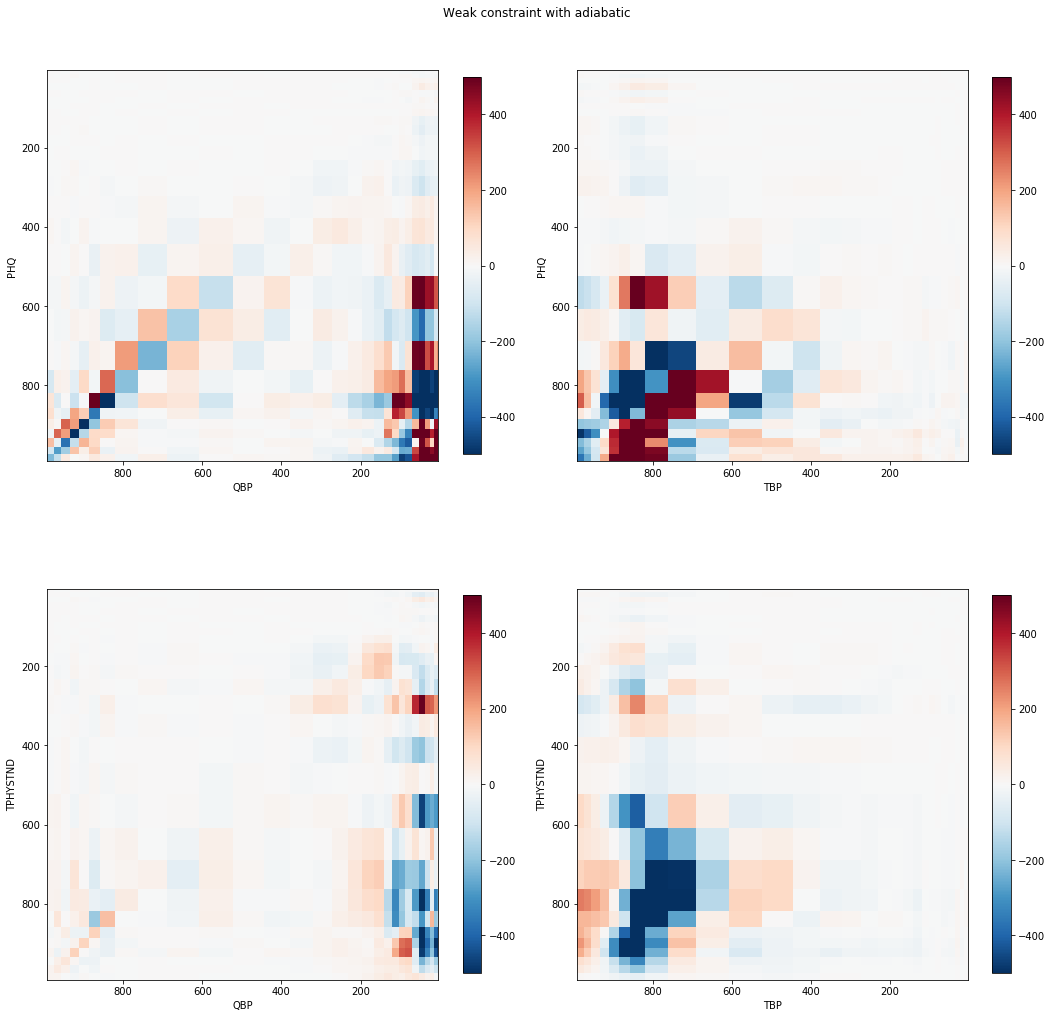

In [118]:
fig, axs = plt.subplots(2, 2, figsize=(15,15))
plot_jacobian(J3, md3.valid_gen, inp_var='QBP', out_var='PHQ', cmap='RdBu_r', vmin=-500, vmax=500, ax=axs[0,0])
plot_jacobian(J3, md3.valid_gen, inp_var='TBP', out_var='PHQ', cmap='RdBu_r', vmin=-500, vmax=500, ax=axs[0,1])
plot_jacobian(J3, md3.valid_gen, inp_var='QBP', out_var='TPHYSTND', cmap='RdBu_r', vmin=-500, vmax=500, ax=axs[1,0])
plot_jacobian(J3, md3.valid_gen, inp_var='TBP', out_var='TPHYSTND', cmap='RdBu_r', vmin=-500, vmax=500, ax=axs[1,1])
plt.suptitle('Weak constraint with adiabatic')
plt.tight_layout()

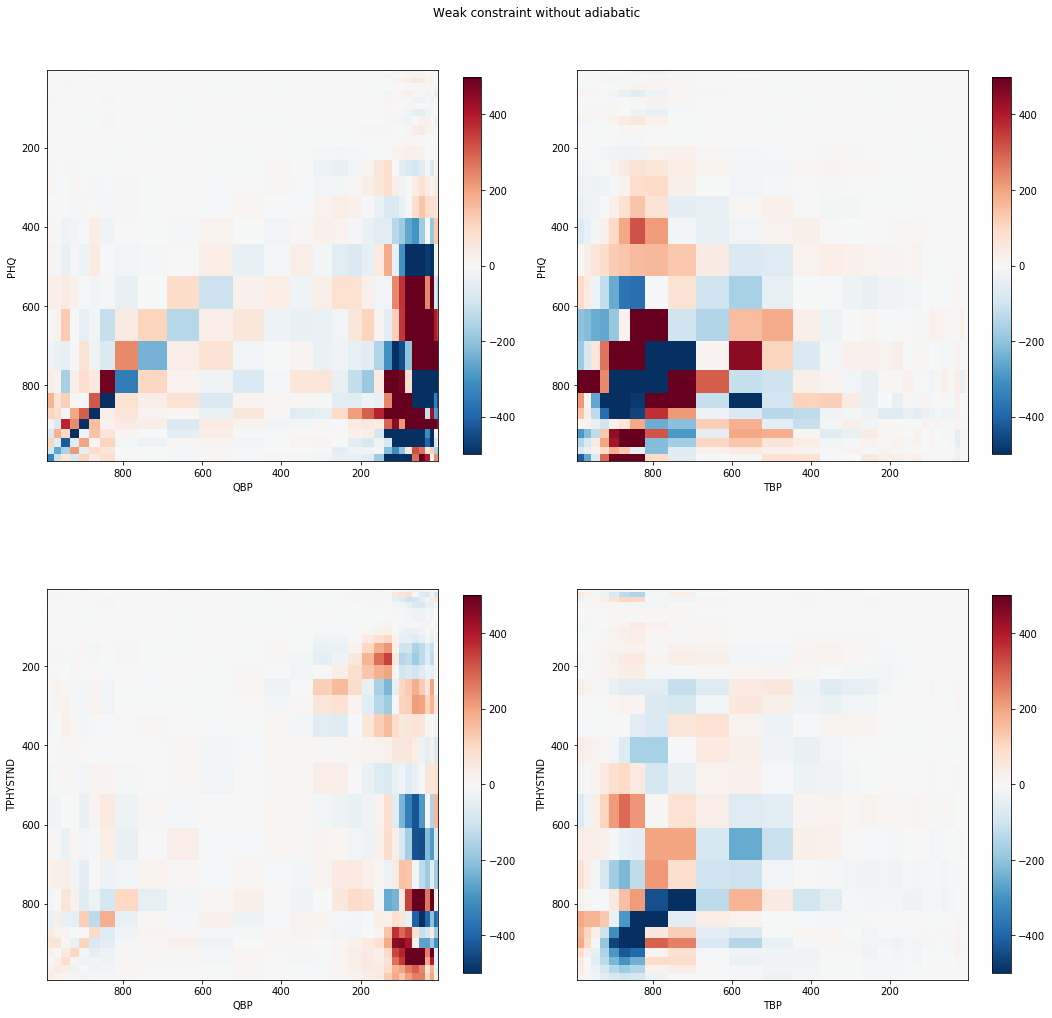

In [120]:
fig, axs = plt.subplots(2, 2, figsize=(15,15))
plot_jacobian(J4, md4.valid_gen, inp_var='QBP', out_var='PHQ', cmap='RdBu_r', vmin=-500, vmax=500, ax=axs[0,0])
plot_jacobian(J4, md4.valid_gen, inp_var='TBP', out_var='PHQ', cmap='RdBu_r', vmin=-500, vmax=500, ax=axs[0,1])
plot_jacobian(J4, md4.valid_gen, inp_var='QBP', out_var='TPHYSTND', cmap='RdBu_r', vmin=-500, vmax=500, ax=axs[1,0])
plot_jacobian(J4, md4.valid_gen, inp_var='TBP', out_var='TPHYSTND', cmap='RdBu_r', vmin=-500, vmax=500, ax=axs[1,1])
plt.suptitle('Weak constraint without adiabatic')
plt.tight_layout()

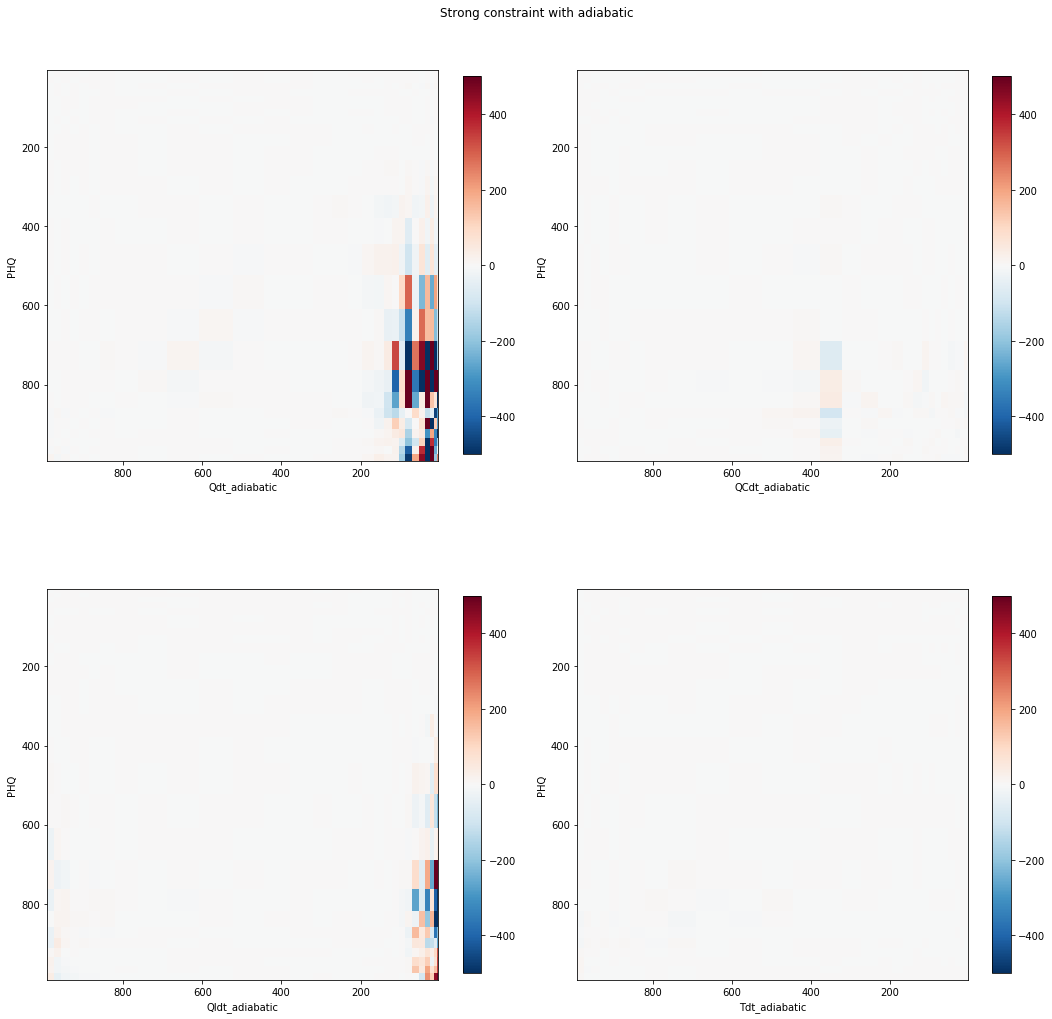

In [124]:
fig, axs = plt.subplots(2, 2, figsize=(15,15))
plot_jacobian(J2, md3.valid_gen, inp_var='Qdt_adiabatic', out_var='PHQ', cmap='RdBu_r', vmin=-500, vmax=500, ax=axs[0,0])
plot_jacobian(J2, md3.valid_gen, inp_var='QCdt_adiabatic', out_var='PHQ', cmap='RdBu_r', vmin=-500, vmax=500, ax=axs[0,1])
plot_jacobian(J2, md3.valid_gen, inp_var='QIdt_adiabatic', out_var='PHQ', cmap='RdBu_r', vmin=-500, vmax=500, ax=axs[1,0])
plot_jacobian(J2, md3.valid_gen, inp_var='Tdt_adiabatic', out_var='PHQ', cmap='RdBu_r', vmin=-500, vmax=500, ax=axs[1,1])
plt.suptitle('Strong constraint with adiabatic')
plt.tight_layout()

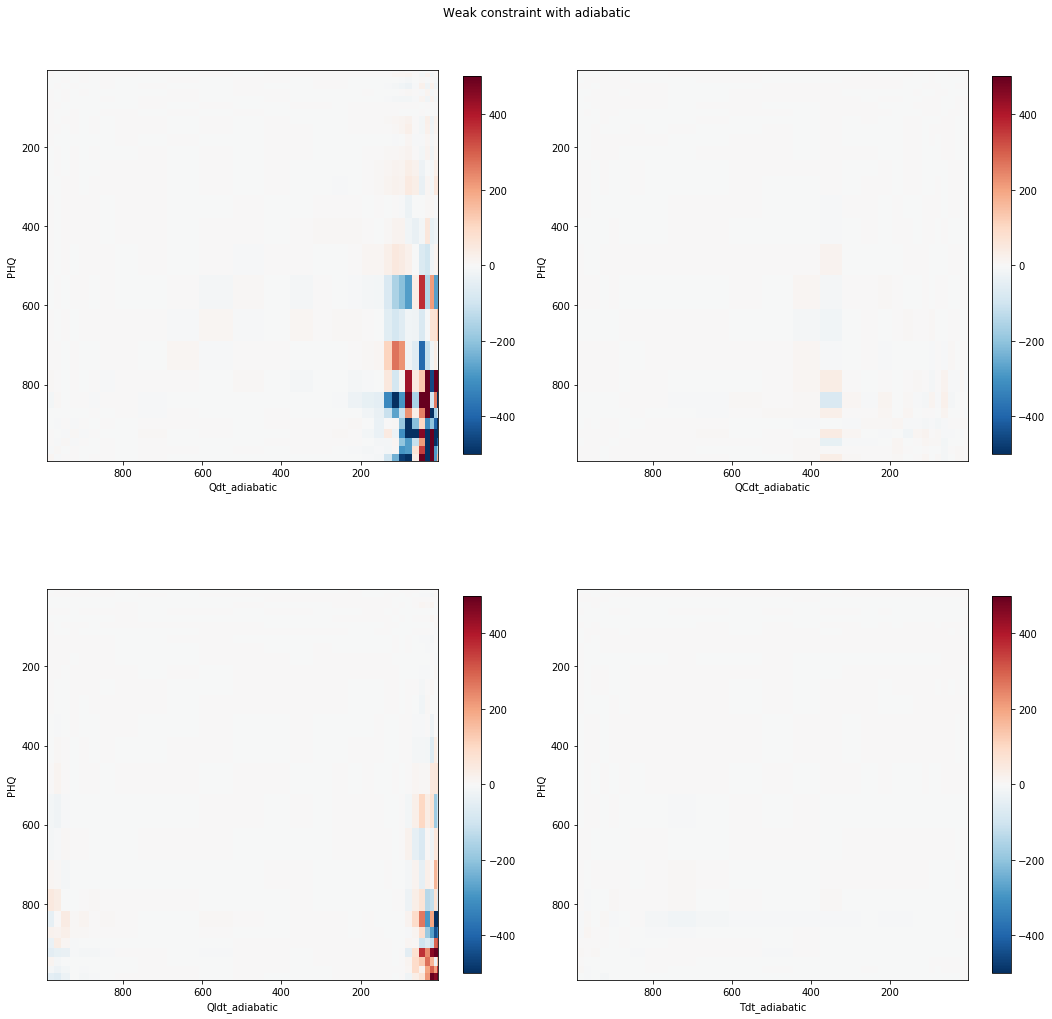

In [123]:
fig, axs = plt.subplots(2, 2, figsize=(15,15))
plot_jacobian(J3, md3.valid_gen, inp_var='Qdt_adiabatic', out_var='PHQ', cmap='RdBu_r', vmin=-500, vmax=500, ax=axs[0,0])
plot_jacobian(J3, md3.valid_gen, inp_var='QCdt_adiabatic', out_var='PHQ', cmap='RdBu_r', vmin=-500, vmax=500, ax=axs[0,1])
plot_jacobian(J3, md3.valid_gen, inp_var='QIdt_adiabatic', out_var='PHQ', cmap='RdBu_r', vmin=-500, vmax=500, ax=axs[1,0])
plot_jacobian(J3, md3.valid_gen, inp_var='Tdt_adiabatic', out_var='PHQ', cmap='RdBu_r', vmin=-500, vmax=500, ax=axs[1,1])
plt.suptitle('Weak constraint with adiabatic')
plt.tight_layout()

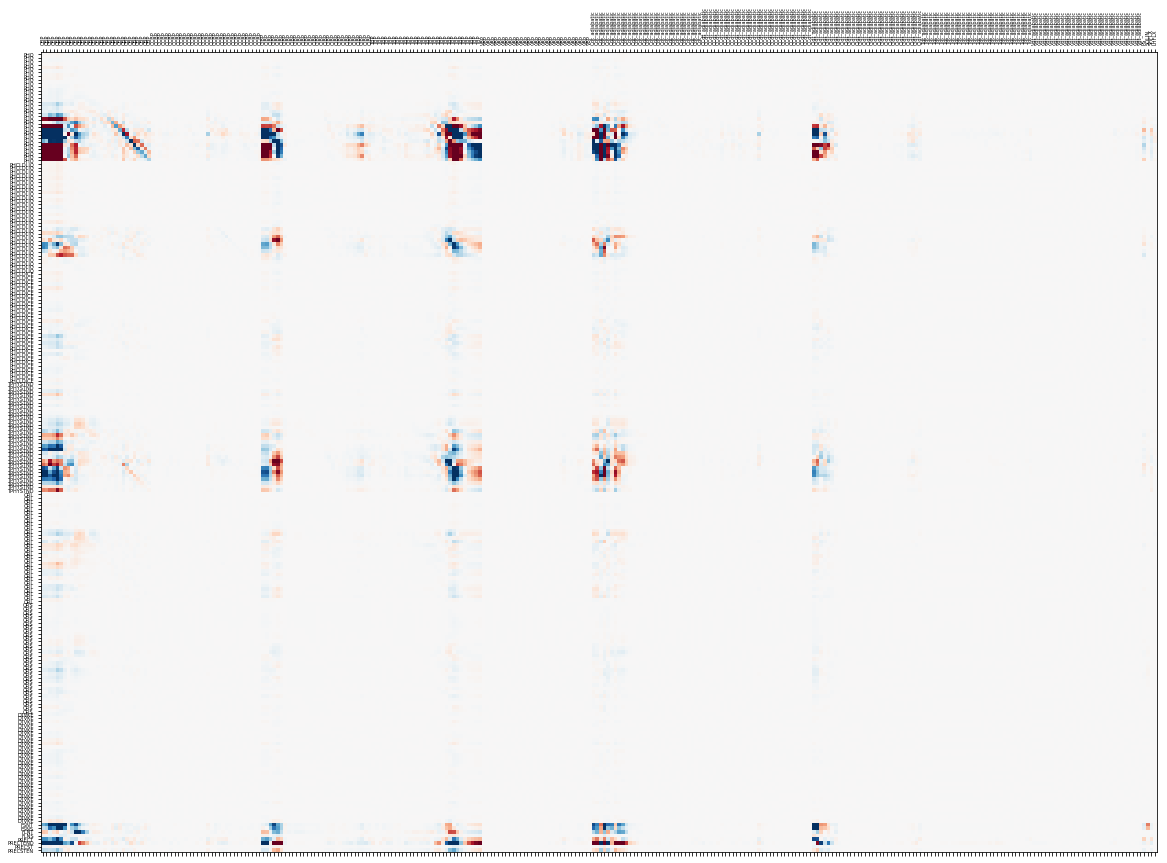

In [59]:
fig, ax = plt.subplots(figsize=(20, 20))
ax.matshow(J, vmin=-500, vmax=500, cmap='RdBu_r')
ax.set_aspect('equal')
plt.xticks(range(md3.valid_gen.n_inputs), md3.valid_gen.norm_ds.var_names[md3.valid_gen.input_idxs].values, rotation=90, fontsize=5);
plt.yticks(range(md3.valid_gen.n_outputs), md3.valid_gen.norm_ds.var_names[md3.valid_gen.output_idxs].values, rotation=0, fontsize=5);